In [1]:
import os, sys
import time
import numpy as np
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import scipy.linalg as spla
import sklearn
from sklearn.manifold import TSNE
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV
import torch
from tqdm import tqdm
# import torchvision
# import torchvision.datasets as datasets
# from torchvision import transforms
# from torch.utils.data import DataLoader
# from collections import OrderedDict
# from numpy.polynomial.chebyshev import chebval
# from ml_collections import config_dict
# import scipy.sparse as sparse
# from functools import partial
# import copy
# from dppy.finite_dpps import FiniteDPP

root_dir = r'..'
SEED = 42
TOL_FP = 1e-12

plt.rc('font', weight='bold', size=20)
plt.rc('legend', fontsize=16)
plt.rc('lines', linewidth=3, markersize=9)
mpl.rcParams['axes.grid'] = True
markers = ['o','^','s','p','d']
colors_10 = list(mcolors.TABLEAU_COLORS.values())
colors_148 = list(mcolors.CSS4_COLORS.values())

In [2]:
np.finfo(np.float32).max

3.4028235e+38

# Datasets

In [3]:
def genenrate_gmm_dataset(N, r, n_cluster, std_max=0.1, seed=0):
    '''
    Output
    -----
    * target: dict('A':ndarray(shape=(m,n)),
                   'U':ndarray(shape=(m,r)),
                   's':ndarray(shape=(r,)),
                   'V':ndarray(shape=(n,r)),
                   'tag':string)
    '''
    # cluster centers: uniform size
    # features = np.repeat((10 * np.arange(1, 1+n_cluster)).reshape(-1,1) * np.eye(r)[:n_cluster], repeats=N//n_cluster, axis=0)
    # cluster centerns: random size
    rng = np.random.default_rng(seed)
    breakpoints = np.sort(rng.integers(1, N-1, n_cluster-1)).astype(int)
    cluster_sizes = np.append(breakpoints, N) - np.insert(breakpoints, 0, 0)
    cluster_center_norm = rng.integers(1, 1+n_cluster, n_cluster) * n_cluster
    cluster_centers = cluster_center_norm.reshape(-1,1) * np.eye(r)[:n_cluster] #(n_cluster, r)
    cluster_std = std_max * rng.random(n_cluster) #(n_cluster,)
    latent_ground_truth = np.concatenate([rng.normal(size=n_cluster), np.zeros(r-n_cluster)]) #(r,)
    cluster_labels = cluster_centers @ latent_ground_truth #(n_cluster,)
    features = np.repeat(cluster_centers, repeats=cluster_sizes, axis=0) #(N, r)
    std = np.repeat(cluster_std, repeats=cluster_sizes) #(N,)
    labels = np.repeat(cluster_labels, repeats=cluster_sizes) #(N,)
    N, r = features.shape
    features += rng.normal(size=(N,r)) * std.reshape(-1,1)
    U,s,Vh = spla.svd(features, full_matrices=False)
    ground_truth = Vh.T @ (U.T @ labels / s)
    dataset = {
        'fea': features,
        'label': labels,
        'latent_ground_truth': latent_ground_truth,
        'ground_truth': ground_truth,
        'svecl': U,
        'sval': s,
        'svecr': Vh.T,
        'N': N,
        'r': r,
        'n_cls': n_cluster,
        'cls_mean': cluster_centers,
        'cls_norm': cluster_center_norm,
        'cls_size': cluster_sizes,
        'cls_std': cluster_std,
    }
    return dataset

N=4000
r=4200
n_cluster=20
gmm_dataset = genenrate_gmm_dataset(N, r, n_cluster)
print(gmm_dataset['cls_size'])
print(gmm_dataset['cls_std'])
print(np.unique(gmm_dataset['label']))

[ 67  97 137 400 378 152 783  30 130  65 187 102  19  50 320 335 149 249
 232 118]
[0.00283197 0.01242833 0.06706244 0.06471895 0.06153851 0.03836776
 0.09972099 0.09808353 0.0685542  0.06504593 0.06884467 0.03889214
 0.01350965 0.07214883 0.05253543 0.03102419 0.04858354 0.08894878
 0.09340435 0.03577952]
[-4.78444902e+02 -4.63810127e+02 -4.10828335e+02 -1.42094156e+02
 -1.32340514e+02 -5.02276503e+01 -3.56330650e-01  5.28911261e+00
  7.90244120e+00  2.62589974e+01  2.78417090e+01  3.60326974e+01
  9.45700129e+01  1.07214123e+02  1.81670853e+02  2.18767192e+02
  4.20833205e+02  4.57597644e+02  4.70461996e+02  5.24887446e+02]


In [4]:
skfeature_for_scores = gmm_dataset['fea'] @ np.random.randn(gmm_dataset['r'], 42)

def check_risks(solution, ground_truth, feature, label, tag='', coreset=None, verbose=True):
    N = feature.shape[0]
    residual = label - solution.predict(feature)
    risk = np.sum(residual**2) / N
    dtheta = solution.coef_ - ground_truth
    theta_relerr = np.linalg.norm(dtheta) / np.linalg.norm(ground_truth)
    if coreset is None:
        if verbose:
            print(f'{tag}{risk:.2e}, theta relative error: {theta_relerr:.2e}')
        return risk
    else:
        GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
        tscore = np.linalg.norm(GG_Sinv, ord='fro')**2 * len(coreset) / N
        escore = np.linalg.norm(GG_Sinv, ord=2)**2 * len(coreset) / N
        if verbose:
            print(f'{tag}{risk:.2e}, theta relative error: {theta_relerr:.2e}, trace score: {tscore:.2e}, eigenvalue score: {escore:.2e}')
        return risk, tscore, escore

linear_regression = sklearn.linear_model.LinearRegression(fit_intercept=False)
solution_full_lr = linear_regression.fit(gmm_dataset['fea'], gmm_dataset['label'])
risk = check_risks(solution_full_lr, gmm_dataset['ground_truth'], gmm_dataset['fea'], gmm_dataset['label'], f'Full data LR risk: ')

Full data LR risk: 5.25e-24, theta relative error: 1.32e-11


## Spectrum

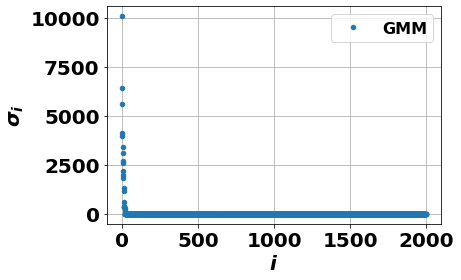

0.023773594415870705 10073.484720126195
Intrinsic dimension-1: 231 / 4000
Intrinsic dimension-0.5: 20 / 4000


In [5]:
def visualize_spec(spectra, range=200):
    plt.figure()
    for name, spec in spectra.items():
        plt.plot(spec[:range], '.', label=name)
    plt.xlabel('$i$')
    plt.ylabel('$\sigma_i$')
    plt.legend()
    plt.show()

visualize_spec({'GMM':gmm_dataset['sval']}, range=2000)
print(np.min(gmm_dataset['sval']), np.max(gmm_dataset['sval']))


def intrinsic_dim(sval, percent_data=1.0, visualize=False):
    tsvd_err = np.cumsum(sval[::-1]**2)
    threshold = np.sum(sval**2) / (N * percent_data)
    if visualize:
        plt.figure()
        plt.plot(np.arange(len(tsvd_err)), tsvd_err)
        plt.plot(np.arange(len(tsvd_err)), np.ones_like(tsvd_err) * threshold)
    dim_int = np.sum(tsvd_err >= threshold)
    print(f'Intrinsic dimension-{percent_data}: {dim_int} / {len(sval)}')
    return dim_int

dim_int = intrinsic_dim(gmm_dataset['sval'], visualize=False, percent_data=1)
dim_int = intrinsic_dim(gmm_dataset['sval'], visualize=False, percent_data=0.5)

## TSNE

/Users/ydong/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


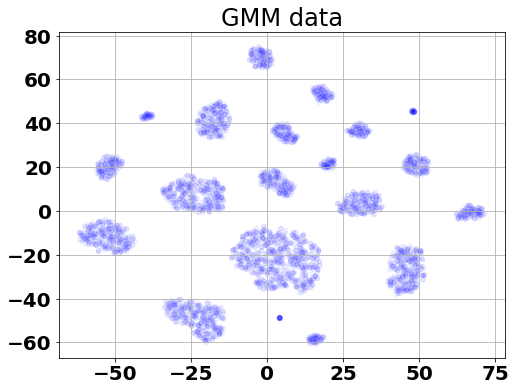

In [6]:
def tsne_visualization(dataset, coreset=None, pca_dim=n_cluster, tag=''):
    labels = dataset['label']
    tsne = TSNE(n_components=2, random_state=0, init='pca', learning_rate='auto')
    data_2d = tsne.fit_transform(dataset['svecl'][:,:pca_dim])
    plt.figure(figsize=(8, 6))
    for i, y in enumerate(np.unique(labels)):
        plt.scatter(
            data_2d[labels==y, 0], data_2d[labels==y, 1], label=f'{y:.2f}',
            c='b',
            alpha=0.05,
            marker='.'
        )
    if coreset is not None:
        plt.scatter(
            data_2d[coreset, 0], data_2d[coreset, 1],
            c='r',
            alpha=1,
            marker='.',
        )
    ax = plt.gca()
    ax.set_title(f'{tag}')
    # ax.set_xticks([])
    # ax.set_yticks([])
    # handles, plabels = ax.get_legend_handles_labels()
    # lgd = ax.legend(handles, plabels, loc='upper left', bbox_to_anchor=(-0.2, -0.12), ncol=5)
    plt.show()

tsne_visualization(gmm_dataset, tag='GMM data')

# Training on Full Data

In [122]:
def solve_ridge_regression(para_grid, feature, label, verbose=True):
    ridge_regression_base = sklearn.linear_model.Ridge(solver='lsqr', fit_intercept=False, random_state=None)
    # search = HalvingGridSearchCV(ridge_regression_base, para_grid, n_jobs=-1, cv=2).fit(feature, label)
    search = GridSearchCV(ridge_regression_base, para_grid, n_jobs=-1, cv=2, scoring='neg_mean_squared_error').fit(feature, label)
    sol = search.best_estimator_
    if verbose:
        best_alpha = search.best_params_['alpha']
        print(f'Best parameters: {best_alpha:.2e}')
    return sol

para_grid = {
    'alpha': np.logspace(-5, 5, 100),
    # 'alpha': np.linspace(50, 100, 100),
    # 'solver': ['lsqr', 'auto'],
}
sol = solve_ridge_regression(para_grid, gmm_dataset['fea'], gmm_dataset['label'])
risk = check_risks(sol, gmm_dataset['ground_truth'], gmm_dataset['fea'], gmm_dataset['label'], f'Full RR risk: ')

/Users/ydong/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: 1.00e-05
Full RR risk: 2.85e-01, theta relative error: 9.72e-01


# Utils: adaptive sampling

In [8]:
def rpid(X, k, mode='rp', rng=None):
    '''
    * X: ndarray(n,d)
    * k: target rank
    * mode: choices=['rp','gp']
    * Adapting https://github.com/dyjdongyijun/Robust_Blockwise_Random_Pivoting
    '''
    n, d = X.shape
    row_perm = np.arange(n)
    rng = np.random.default_rng(seed=SEED) if rng is None else rng

    diags = spla.norm(X, ord=2, axis=1)**2 #(n,)
    # residual = sum(diags)

    L = np.zeros((n,k))
    Q = np.zeros((d,k))
    # residuals = [residual]
    for i in range(k):
        candidates = row_perm[i:]
        if mode == 'rp':
            j = i + rng.choice(n-i, p = diags[candidates] / sum(diags[candidates]))
        elif mode == 'gp':
            j = i + rng.choice(np.where(diags[candidates] == np.max(diags[candidates]))[0])
        else:
            raise RuntimeError(f"Algorithm '{mode}' not recognized")
        row_perm[[i, j]] = row_perm[[j, i]]
        idx = row_perm[i]
        if i==0:
            v = X[idx]
        else:
            v = X[idx] - Q[:,:i] @ (Q[:,:i].T @ X[idx])
        Q[:,i] = v / np.sqrt(np.sum(v**2))
        a = X[row_perm[i:]] @ v
        L[row_perm[i:],i] = (a / np.sqrt(a[0]))

        diags[row_perm[i+1:]] -= L[row_perm[i+1:],i]**2
        diags[idx] = 0 # for sanity only
        diags = diags.clip(min=0)
        # residual = sum(diags[row_perm[i+1:]])

        # residuals.append(residual)
        if np.count_nonzero(diags[row_perm[i+1:]]) < 1:
            L = L[:,:i+1]
            k = i+1
            break

    # residuals = np.array(residuals[1:])/residuals[0]
    coreset = row_perm[:k]
    return coreset


def _block_size_local_clip(R, tol,):
    rncs = np.flip(np.flip(spla.norm(R, ord=2, axis=1)**2).cumsum()) # row norms cumsum
    relative_rncs = rncs / rncs[0] #/ np.arange(R.shape[0],0,-1)
    block_size = R.shape[0] if relative_rncs[-1] >= tol else np.argmax(relative_rncs < tol)
    return block_size


def blocked_rpid(X, k, b=20, mode='rp', tol_loc=None):
    '''
    * X: ndarray(n,d)
    * k: target rank
    * mode: choices=['rp','gp']
    * ortho: whether using ORP/OGP
        - ortho==0: RP/GP, unstable
        - ortho==1: ORP/OGP, orthogonalization, block lower triangular L, approximated, most stable with solve_triangular(L1.T, L2.T).T
        - ortho==2: O2RP/O2GP, orthogonalization, lower triangular L, exact, more stable with SVD
    '''
    n, d = X.shape
    row_perm = np.arange(n)
    rng = np.random.default_rng(seed=SEED)
    tol_loc = 1/b if tol_loc is None else tol_loc

    diags = spla.norm(X, ord=2, axis=1)**2 #(n,)
    # residual = sum(diags)
    L = np.zeros((n,k))
    Q = np.zeros((d,k))
    # residuals = [residual]
    ranks = []

    i = 0
    while i < k:
        block_size = min(k-i, b, np.count_nonzero(diags[row_perm[i:]]))
        if mode == 'rp':
            js = i + rng.choice(n-i, size=block_size, p = diags[row_perm[i:]] / sum(diags[row_perm[i:]]), replace=False)
            # js = np.unique(js)[:block_size]
            block_size = len(js)
        elif mode == 'gp':
            js = i + np.argpartition(diags[row_perm[i:]], -block_size)[-block_size:]
        else:
            raise RuntimeError(f"Algorithm '{mode}' not recognized")

        if i==0:
            V = X[row_perm[js]].T #(d,b)
        else:
            V = X[row_perm[js]].T - Q[:,:i] @ (Q[:,:i].T @ X[row_perm[js]].T) #(d,b), cost = O(dbi)

        QV, RV, pV = spla.qr(V, mode='economic', pivoting=True) #(d,b), (b,b), (b,)
        block_size = _block_size_local_clip(RV, tol_loc)
        js = js[pV[:block_size]]
        # row_perm[i:i+block_size], row_perm[js] = row_perm[js], row_perm[i:i+block_size] # bug
        aux = row_perm[i:i+block_size]
        row_perm[i:i+block_size] = row_perm[js]
        row_perm[js] = aux
        Q[:,i:i+block_size] = QV[:,:block_size]

        L[row_perm[i:],i:i+block_size] = X[row_perm[i:]] @ Q[:,i:i+block_size]

        diags[row_perm[i+block_size:]] -= np.sum(L[row_perm[i+block_size:],i:i+block_size]**2, axis=1)
        # diags[row_perm[:i+block_size]] = 0 # for sanity only
        diags = diags.clip(min=0)
        # residual = sum(diags[row_perm[i+block_size:]])
        i += block_size

        # residuals.append(residual)
        ranks.append(i)
        if np.count_nonzero(diags[row_perm[i+1:]]) < 1:
            L = L[:,:i]
            k = i
            break
    # residuals = np.array(residuals[1:])/residuals[0]
    coreset = row_perm[:k]
    return coreset

# Data Selection

In [9]:
risks = []
tscores = []
escores = []

In [114]:
n = 200

## Uniform

Best parameters: 1.15e+01
RR risk: 1.32e+00, theta relative error: 9.72e-01, trace score: 5.47e+01, eigenvalue score: 3.35e+00


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/Users/ydong/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


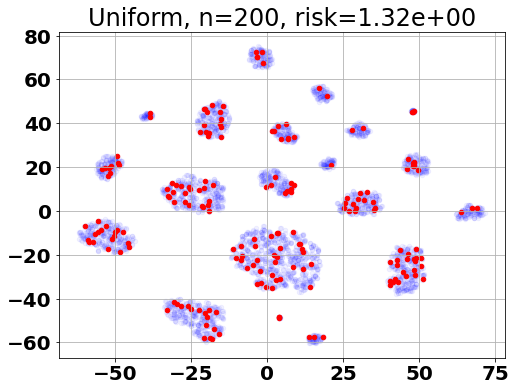

Uniform, n=200, risk=1.32e+00 +- 0.00e+00


In [123]:
loss = []
for seed in np.random.randint(0, 100, 1):
# for seed in np.arange(10):
    tag = f'Uniform, n={n}'
    rng = np.random.default_rng(seed=seed)
    coreset = rng.choice(N, n, replace=False)
    solution_uniform_rr = solve_ridge_regression(para_grid, gmm_dataset['fea'][coreset], gmm_dataset['label'][coreset])
    risk, tscore, escore = check_risks(solution_uniform_rr, gmm_dataset['ground_truth'], gmm_dataset['fea'], gmm_dataset['label'], f'RR risk: ', coreset)
    loss.append(risk)
    risks.append(risk)
    tscores.append(tscore)
    escores.append(escore)
tsne_visualization(gmm_dataset, coreset=coreset, tag=tag+f', risk={risk:.2e}')
print(f'Uniform, n={n}, risk={np.mean(loss):.2e} +- {np.std(loss):.2e}')

## SkMM

Sketch dimension: 40


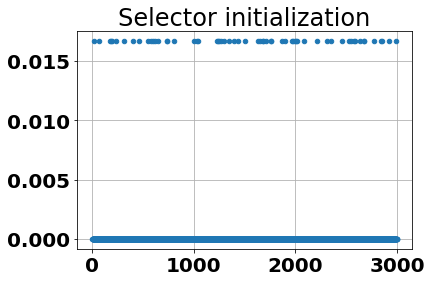

Loss: 6.10e+04 | MM: 6.10e+04 | Sparsity: 6.13e+01:   0%|          | 0/30000 [00:00<?, ?it/s]

Loss: 6.48e+04 | MM: 6.48e+04 | Sparsity: 6.00e+01


Loss: 2.20e+03 | MM: 2.20e+03 | Sparsity: 7.46e+02:  20%|██        | 6112/30000 [00:09<00:37, 635.68it/s]

Loss: 2.32e+03 | MM: 2.32e+03 | Sparsity: 7.15e+02


Loss: 2.05e+02 | MM: 2.05e+02 | Sparsity: 2.53e+03:  40%|████      | 12129/30000 [00:18<00:27, 643.04it/s]

Loss: 2.14e+02 | MM: 2.14e+02 | Sparsity: 2.51e+03


Loss: 4.08e+01 | MM: 4.08e+01 | Sparsity: 2.97e+03:  60%|██████    | 18074/30000 [00:28<00:18, 652.02it/s]

Loss: 4.18e+01 | MM: 4.18e+01 | Sparsity: 2.97e+03


Loss: 2.26e+01 | MM: 2.26e+01 | Sparsity: 3.00e+03:  80%|████████  | 24069/30000 [00:37<00:09, 655.83it/s]

Loss: 2.27e+01 | MM: 2.27e+01 | Sparsity: 3.00e+03


Loss: 2.30e+01 | MM: 2.30e+01 | Sparsity: 3.00e+03: 100%|██████████| 30000/30000 [00:46<00:00, 647.35it/s]


In [143]:
def sketchy_mm_selection(dataset, n, sketch_dim=10, mm_coef=0.999, sparsity_reg=1e1, optimizer='Adam', lr=1e-6, momentum=0.9, num_iter=1e4, seed=42):
    np.random.seed(seed) # control sketching
    torch.manual_seed(seed) # control initialization

    feature = dataset['fea']
    if sketch_dim > 0:
        feature = feature @ np.random.randn(feature.shape[1], sketch_dim) / np.sqrt(sketch_dim) # (N, sketch_dim)
        _, sval_, svecrT_ = spla.svd(feature, full_matrices=False)
        eigvec = torch.from_numpy(svecrT_.T).float() # (sketch_dim,sketch_dim)
        eigval = torch.from_numpy(sval_**2 / dataset['N']).float() # (sketch_dim,)
    else:
        sketch_dim = feature.shape[1]
        eigvec = torch.from_numpy(dataset['svecr']).float() # (r,r)
        eigval = torch.from_numpy(dataset['sval']**2 / dataset['N']).float() # (r,)
    feature = torch.from_numpy(feature).float()

    # projected GD
    uniform_init = torch.randperm(dataset['N'])[:n]
    selector = torch.zeros(dataset['N'])
    selector[uniform_init] = 1. / n
    selector_np = selector.detach().numpy()
    plt.figure()
    plt.plot(selector_np/np.sum(selector_np), '.')
    plt.title('Selector initialization')
    plt.show()
    multiplier = 1/mm_coef + torch.rand(sketch_dim)* (1-1/mm_coef)
    selector.requires_grad_()
    multiplier.requires_grad_()
    if optimizer == 'SGD':
        optimizer = torch.optim.SGD([selector, multiplier], lr=lr, momentum=momentum)
    elif optimizer == 'Adam':
        optimizer = torch.optim.Adam([selector, multiplier], lr=lr)
    else:
        raise NotImplementedError(f'Optimizer {optimizer} not implemented')

    training_bar = tqdm(range(int(num_iter)))
    best_selector = selector.detach().clone()
    best_mm = torch.tensor(float('inf'))
    for i in training_bar:
        optimizer.zero_grad()
        rotated_coreset_moment_diag = ((((feature.transpose(1,0) * selector) @ feature) @ eigvec) * eigvec).sum(axis=0)
        mm_objective = (rotated_coreset_moment_diag - multiplier * eigval).pow(2).sum()
        regularization = selector.abs().sum().pow(2) / selector.pow(2).sum()
        loss = mm_objective #+ regularization * sparsity_reg
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            selector.clamp_(min=0, max=1./n)
            selector /= selector.sum()
            multiplier.clamp_(min=1/mm_coef)
        if mm_objective < best_mm:
            best_mm = mm_objective
            best_selector = selector.detach().clone()
        log = f'Loss: {loss.item():.2e} | MM: {mm_objective.item():.2e} | Sparsity: {regularization.item():.2e}'
        training_bar.set_description(log)
        if i % (num_iter//5) == 0:
            print(log)
    output = {
        'best_selector': best_selector.detach().numpy(),
        'best_mm': best_mm.item(),
        'selector': selector.detach().numpy(),
        'multiplier': multiplier.detach().numpy(),
    }
    return output


def hybrid_selector(distrib, nsmp, rng, topk=0.0):
    ntopk = np.floor(nsmp * topk).astype(int)
    idx_topk = np.argpartition(distrib, -ntopk)[-ntopk:] if ntopk > 0 else []
    distrib_ = np.array(distrib)
    distrib_[idx_topk] = 0
    if sum(distrib_) > 0:
        idx_rand = rng.choice(len(distrib), size=nsmp-ntopk, replace=False, p=distrib_/np.sum(distrib_))
    else:
        idx_rand = rng.choice(len(distrib), size=nsmp-ntopk, replace=False)
    coreset = np.concatenate([idx_topk, idx_rand])
    return coreset.astype(int)

tag = f'SkMM, n={n}'
sketch_dim = int(np.ceil(n_cluster*4))
print(f'Sketch dimension: {sketch_dim}')
skmm = sketchy_mm_selection(gmm_dataset, n, sketch_dim=sketch_dim, mm_coef=0.999, sparsity_reg=1e1, optimizer='Adam', lr=1e-7, momentum=0.9, num_iter=3e4, seed=1)

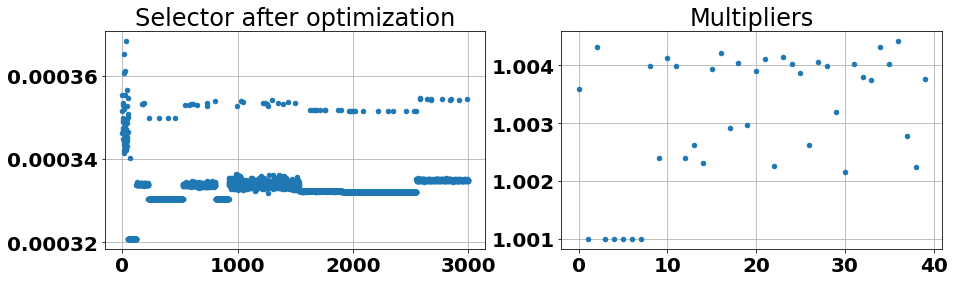

Best parameters: 1.00e-03
RR risk: 2.25e+00, theta relative error: 8.65e-01, trace score: 1.22e+04, eigenvalue score: 1.19e+04


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_36071/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/Users/ydong/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


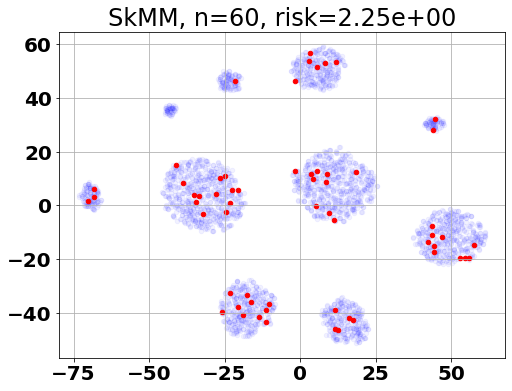

In [144]:
selector_np = skmm['best_selector']
multiplier_np = skmm['multiplier']
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.plot(selector_np, '.')
plt.title('Selector after optimization')
plt.subplot(1,2,2)
plt.plot(multiplier_np, '.')
plt.title('Multipliers')
plt.show()

rng = np.random.default_rng(seed=1)
coreset = rng.choice(N, n, p=selector_np/np.sum(selector_np), replace=False)
# coreset = np.argpartition(selector_np, -n)[-n:]
# coreset = hybrid_selector(selector_np, n, rng, topk=0.5)

solution_ = solve_ridge_regression(para_grid, gmm_dataset['fea'][coreset], gmm_dataset['label'][coreset])
risk, tscore, escore = check_risks(solution_, gmm_dataset['ground_truth'], gmm_dataset['fea'], gmm_dataset['label'], f'RR risk: ', coreset)
tsne_visualization(gmm_dataset, coreset=coreset, tag=tag+f', risk={risk:.2e}')
risks.append(risk)
tscores.append(tscore)
escores.append(escore)

## SkMMv2

In [124]:
def SkMMv2_stable(feature, n, m, b=1, sampler='exp', temperature=1e-3, rng=None):
    if rng is None:
        rng = np.random.default_rng(seed=42)
    N, r = feature.shape
    if n - m < 20:
        m = max(n-20, n//2)
    skfeature_ = feature @ rng.normal(size=(r,m)) / np.sqrt(m)
    _, R = np.linalg.qr(skfeature_) #(m,m)
    candidates = np.arange(N)
    coreset = rpid(skfeature_, m, mode='rp', rng=rng)
    skfeature = np.delete(skfeature_, coreset, axis=0)
    candidates = np.delete(candidates, coreset)
    evec,eval,_ = np.linalg.svd(skfeature_[coreset].T, full_matrices=False) #(m,m), (m,)
    for _ in range(m,n,b):
        if len(coreset) + b > n:
            b = n - len(coreset)
        UtX = skfeature @ evec # (N,m)
        cross_leverage = np.linalg.norm(UtX / np.sqrt(eval).reshape(1,-1), axis=1)**2 
        scores = np.linalg.norm((UtX / eval.reshape(1,-1)) @ (evec.T @ R), axis=1)**2 / (1 + cross_leverage)  
        if sampler == 'exp':
            distrib = np.exp(scores/np.sum(scores)/temperature)
            idx = rng.choice(len(candidates), b, p=distrib/np.sum(distrib), replace=False)
        elif sampler == 'linear':
            idx = rng.choice(len(candidates), b, p=scores/np.sum(scores), replace=False)
        elif sampler == 'greedy':
            idx = np.argpartition(scores, -b)[-b:]
        coreset = np.insert(coreset, len(coreset), candidates[idx])
        skfeature = np.delete(skfeature, idx, axis=0)
        candidates = np.delete(candidates, idx)
        evec,eval,_ = np.linalg.svd(skfeature_[coreset].T, full_matrices=False)
    return coreset              


def SkMMv2(feature, n, m, b=1, sampler='exp', temperature=1e-3, rng=None):
    if rng is None:
        rng = np.random.default_rng(seed=42)
    N, r = feature.shape
    if n - m < 20:
        m = max(n-20, n//2)
    skfeature_ = feature @ rng.normal(size=(r,m)) / np.sqrt(m) #(N,m)
    _, R = np.linalg.qr(skfeature_) #(m,m)
    candidates = np.arange(N)
    coreset = rpid(skfeature_, m, mode='rp', rng=rng)
    skfeature = np.delete(skfeature_, coreset, axis=0)
    candidates = np.delete(candidates, coreset)
    evec,eval,_ = np.linalg.svd(skfeature_[coreset].T, full_matrices=False) #(m,m), (m,)
    interpolation = ((skfeature @ evec) / (eval**2).reshape(1,-1)) @ evec.T #(N-m,m)
    for _ in range(m,n,b):
        if len(coreset) + b > n:
            b = n - len(coreset)
        cross_leverage = np.sum(interpolation * skfeature, axis=1) # (N-m,)
        scores = np.linalg.norm(interpolation @ R.T, axis=1)**2 / (1 + cross_leverage) 
        if sampler == 'exp':
            distrib = np.exp(scores/np.sum(scores)/temperature)
            idx = rng.choice(len(candidates), b, p=distrib/np.sum(distrib), replace=False)
        elif sampler == 'linear':
            idx = rng.choice(len(candidates), b, p=scores/np.sum(scores), replace=False)
        elif sampler == 'greedy':
            idx = np.argpartition(scores, -b)[-b:]
        coreset = np.insert(coreset, len(coreset), candidates[idx])
        skfeature_block = skfeature[idx] #(b,m)
        skfeature = np.delete(skfeature, idx, axis=0)
        candidates = np.delete(candidates, idx)
        
        interpolation_block = interpolation[idx] #(b,m)
        interpolation = np.delete(interpolation, idx, axis=0)
        if b==1:
            interpolation = interpolation - np.outer(interpolation @ skfeature_block.T, interpolation_block / (1 + cross_leverage[idx]))
        else:
            evec, eval, _ = np.linalg.svd(interpolation_block @ skfeature_block.T, full_matrices=False) # (b,b), (b,)
            interpolation = interpolation - (interpolation @ skfeature_block.T) @ (evec / (1+eval).reshape(1,-1) @ (evec.T @ interpolation_block))
    return coreset        

/Users/ydong/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: 1.48e+02
RR risk: 2.88e-01, theta relative error: 9.72e-01, trace score: 4.90e+01, eigenvalue score: 3.35e+00


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/Users/ydong/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


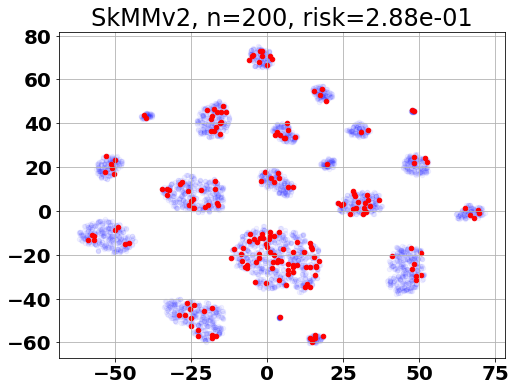

SkMMv2, n=200, risk=2.88e-01 +- 0.00e+00


In [131]:
loss = []
for seed in np.random.randint(0, 100, 1):
# for seed in np.arange(10):
    tag = f'SkMMv2, n={n}'
    rng = np.random.default_rng(seed=seed)
    coreset = SkMMv2(gmm_dataset['fea'], n, 80, b=1, rng=rng, temperature=1e-3, 
                    #  sampler='greedy',
                    #  sampler='exp',
                     sampler='linear',
                    )
    solution_uniform_rr = solve_ridge_regression(para_grid, gmm_dataset['fea'][coreset], gmm_dataset['label'][coreset])
    risk, tscore, escore = check_risks(solution_uniform_rr, gmm_dataset['ground_truth'], gmm_dataset['fea'], gmm_dataset['label'], f'RR risk: ', coreset)
    risks.append(risk)
    tscores.append(tscore)
    escores.append(escore)
    loss.append(risk)
tsne_visualization(gmm_dataset, coreset=coreset, tag=tag+f', risk={risk:.2e}')
print(f'SkMMv2, n={n}, risk={np.mean(loss):.2e} +- {np.std(loss):.2e}')

## Ridge leverage score

Best parameters: 1.45e+01
RR risk: 1.38e+00, theta relative error: 9.72e-01, trace score: 5.36e+01, eigenvalue score: 4.77e+00


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/Users/ydong/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


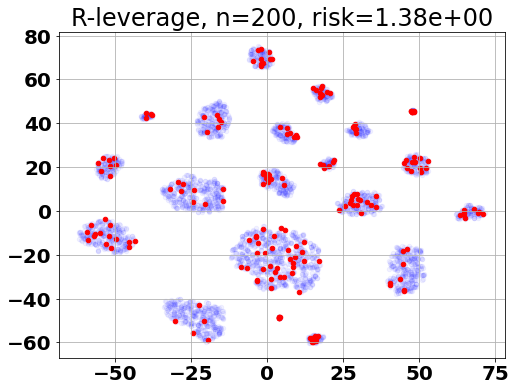

R-leverage, n=200, risk=1.38e+00 +- 0.00e+00


In [132]:
def get_ridge_leverage_score(dataset, alpha=1.0):
    svecl = dataset['svecl']
    sval = dataset['sval']
    svecl_alpha = svecl * (sval / np.sqrt(sval**2 + alpha))
    return np.sum(svecl_alpha**2, axis=1)


loss = []
for seed in np.random.randint(0, 100, 1):
# for seed in np.arange(1):
    tag = f'R-leverage, n={n}'
    # leverage_scores = get_ridge_leverage_score(gmm_dataset, alpha=10)
    leverage_scores = get_ridge_leverage_score(gmm_dataset, alpha=1e4)
    # plt.figure()
    # plt.plot(leverage_scores/np.sum(leverage_scores), '.')
    # plt.title('Leverage scores')
    # plt.show()
    rng = np.random.default_rng(seed=seed)
    coreset = rng.choice(N, n, p=leverage_scores/np.sum(leverage_scores), replace=False)

    solution_ = solve_ridge_regression(para_grid, gmm_dataset['fea'][coreset], gmm_dataset['label'][coreset])
    risk, tscore, escore = check_risks(solution_, gmm_dataset['ground_truth'], gmm_dataset['fea'], gmm_dataset['label'], f'RR risk: ', coreset)
    risks.append(risk)
    tscores.append(tscore)
    escores.append(escore)
    loss.append(risk)
tsne_visualization(gmm_dataset, coreset=coreset, tag=tag+f', risk={risk:.2e}')
print(f'R-leverage, n={n}, risk={np.mean(loss):.2e} +- {np.std(loss):.2e}')

## Sketched Ridge Leverage Score

Best parameters: 1.15e+01
RR risk: 9.06e+00, theta relative error: 9.72e-01, trace score: 9.53e+01, eigenvalue score: 3.42e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/Users/ydong/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


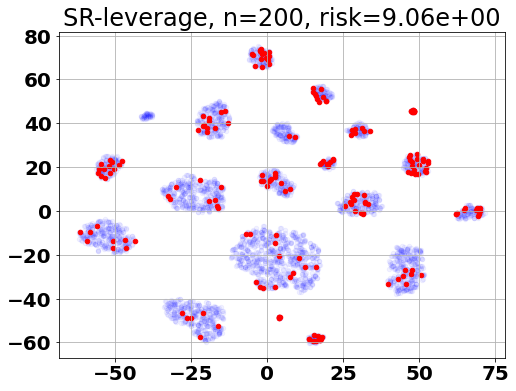

SR-leverage, n=200, risk=9.06e+00 +- 0.00e+00


In [135]:
def get_sketched_ridge_leverage_score(features, sk_dim, alpha=1.0):
    skfea = features @ np.random.randn(features.shape[1], sk_dim) / np.sqrt(sk_dim)
    svecl, sval, _ = spla.svd(skfea, full_matrices=False)
    svecl_alpha = svecl * (sval / np.sqrt(sval**2 + alpha))
    return np.sum(svecl_alpha**2, axis=1)

sketch_dim = 80
loss = []
for seed in np.random.randint(0, 100, 1):
# for seed in np.arange(10):
    tag = f'SR-leverage, n={n}'
    leverage_scores = get_sketched_ridge_leverage_score(gmm_dataset['fea'], sketch_dim, alpha=1e5)
    # plt.figure()
    # plt.plot(leverage_scores/np.sum(leverage_scores), '.')
    # plt.title('Leverage scores')
    # plt.show()
    rng = np.random.default_rng(seed=seed)
    coreset = rng.choice(N, n, p=leverage_scores/np.sum(leverage_scores), replace=False)

    solution_ = solve_ridge_regression(para_grid, gmm_dataset['fea'][coreset], gmm_dataset['label'][coreset])
    risk, tscore, escore = check_risks(solution_, gmm_dataset['ground_truth'], gmm_dataset['fea'], gmm_dataset['label'], f'RR risk: ', coreset)
    risks.append(risk)
    tscores.append(tscore)
    escores.append(escore)
    loss.append(risk)
tsne_visualization(gmm_dataset, coreset=coreset, tag=tag+f', risk={risk:.2e}')
print(f'SR-leverage, n={n}, risk={np.mean(loss):.2e} +- {np.std(loss):.2e}')

## Sqrt leverage score

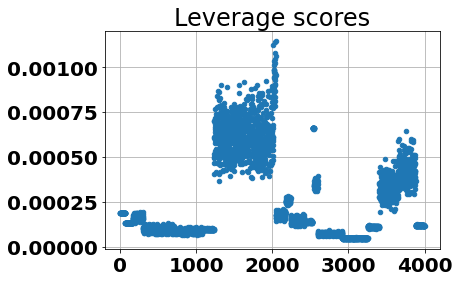

Best parameters: 1.45e+01
RR risk: 5.27e-01, theta relative error: 9.72e-01, trace score: 4.85e+01, eigenvalue score: 3.02e+00


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/Users/ydong/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


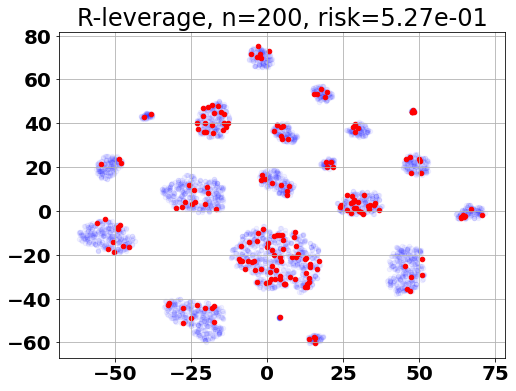

In [136]:
def get_leverage_score(feature, orthogonal=False):
    n, d = feature.shape
    if not orthogonal:
        Q, _ = spla.qr(feature, mode='economic')
        leverage_score = np.sum(Q**2, axis=1)
    else:
        leverage_score = np.sum(feature**2, axis=1)
    return leverage_score

seed = 0
sketch_dim = 80
tag = f'R-leverage, n={n}' 
# leverage_scores = get_ridge_leverage_score(gmm_dataset, alpha=10)
leverage_scores = get_leverage_score(gmm_dataset['svecl'][:,:sketch_dim], orthogonal=True)
plt.figure()
plt.plot(leverage_scores/np.sum(leverage_scores), '.')
plt.title('Leverage scores')
plt.show()
rng = np.random.default_rng(seed=seed)
coreset = rng.choice(N, n, p=np.sqrt(leverage_scores)/np.sum(np.sqrt(leverage_scores)), replace=False)

solution_ = solve_ridge_regression(para_grid, gmm_dataset['fea'][coreset], gmm_dataset['label'][coreset])
risk, tscore, escore = check_risks(solution_, gmm_dataset['ground_truth'], gmm_dataset['fea'], gmm_dataset['label'], f'RR risk: ', coreset)
tsne_visualization(gmm_dataset, coreset=coreset, tag=tag+f', risk={risk:.2e}')
risks.append(risk)
tscores.append(tscore)
escores.append(escore)

## Leverage score

Best parameters: 7.56e+02
RR risk: 4.33e+03, theta relative error: 9.76e-01, trace score: 3.81e+03, eigenvalue score: 3.74e+03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/Users/ydong/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


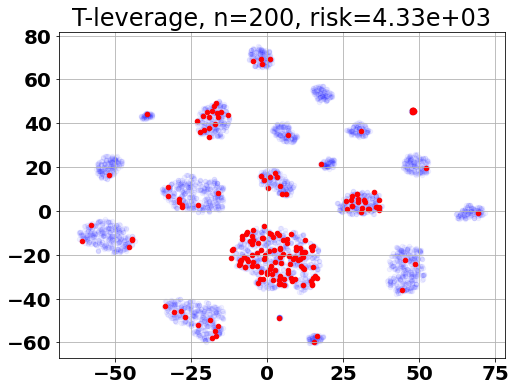

T-leverage, n=200, risk=4.33e+03 +- 0.00e+00


In [138]:
def get_leverage_score(feature, orthogonal=False):
    n, d = feature.shape
    if not orthogonal:
        Q, _ = spla.qr(feature, mode='economic')
        leverage_score = np.sum(Q**2, axis=1)
    else:
        leverage_score = np.sum(feature**2, axis=1)
    return leverage_score


loss = []
sketch_dim = 100
for seed in np.random.randint(0, 100, 1):
    tag = f'T-leverage, n={n}'
    # leverage_scores = get_leverage_score(gmm_dataset['svecl'], orthogonal=True) # plain levarage score
    # leverage_scores = get_leverage_score(gmm_dataset['fea'] @ np.random.randn(gmm_dataset['fea'].shape[1], sketch_dim))
    leverage_scores = get_leverage_score(gmm_dataset['svecl'][:,:sketch_dim], orthogonal=True)
    # plt.figure()
    # plt.plot(leverage_scores/np.sum(leverage_scores), '.')
    # plt.title('Leverage scores')
    # plt.show()
    rng = np.random.default_rng(seed=seed)
    coreset = rng.choice(N, n, p=leverage_scores/np.sum(leverage_scores), replace=False)

    solution_ = solve_ridge_regression(para_grid, gmm_dataset['fea'][coreset], gmm_dataset['label'][coreset])
    risk, tscore, escore = check_risks(solution_, gmm_dataset['ground_truth'], gmm_dataset['fea'], gmm_dataset['label'], f'RR risk: ', coreset)
    risks.append(risk)
    tscores.append(tscore)
    escores.append(escore)
    loss.append(risk)
tsne_visualization(gmm_dataset, coreset=coreset, tag=tag+f', risk={risk:.2e}')
print(f'T-leverage, n={n}, risk={np.mean(loss):.2e} +- {np.std(loss):.2e}')

## Influence function

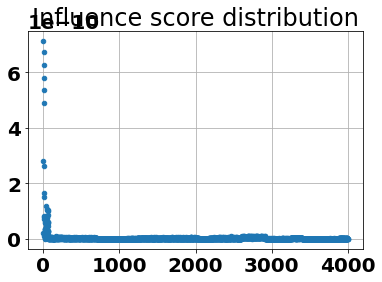

Best parameters: 1.48e+02
RR risk: 2.92e+03, theta relative error: 9.78e-01, trace score: 3.18e+03, eigenvalue score: 3.07e+03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/Users/ydong/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


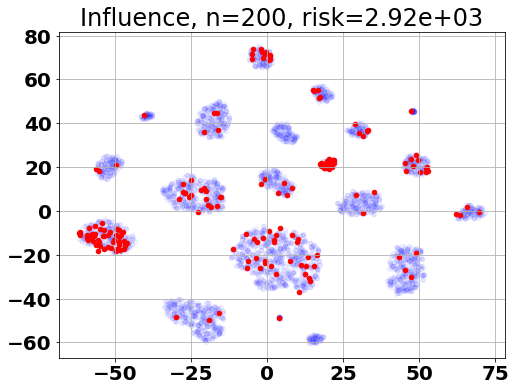

In [139]:
def get_influence(dataset):
    residual = (dataset['label'] - dataset['fea'] @ dataset['ground_truth']).reshape(-1)
    svecl = dataset['svecl']
    sval = dataset['sval']
    aux = np.linalg.norm(svecl/sval, axis=1)
    return np.abs(residual) * aux
    
seed = 0
tag = f'Influence, n={n}'
influence = get_influence(gmm_dataset)
plt.figure()
plt.plot(influence, '.')
plt.title('Influence score distribution')
plt.show()
rng = np.random.default_rng(seed=seed)
coreset = rng.choice(N, n, p=influence/np.sum(influence), replace=False)

solution_ = solve_ridge_regression(para_grid, gmm_dataset['fea'][coreset], gmm_dataset['label'][coreset])
risk, tscore, escore = check_risks(solution_, gmm_dataset['ground_truth'], gmm_dataset['fea'], gmm_dataset['label'], f'RR risk: ', coreset)
tsne_visualization(gmm_dataset, coreset=coreset, tag=tag+f', risk={risk:.2e}')
risks.append(risk)
tscores.append(tscore)
escores.append(escore)

## Adaptive sampling (+ blockwise)

In [140]:
loss = []
for seed in np.random.randint(0, 100, 1):
    tag = f'Adaptive, n={n}'
    rng = np.random.default_rng(seed=seed)
    coreset = rpid(gmm_dataset['fea'], n, mode='rp', rng=rng)
    solution_uniform_rr = solve_ridge_regression(para_grid, gmm_dataset['fea'][coreset], gmm_dataset['label'][coreset])
    risk, tscore, escore = check_risks(solution_uniform_rr, gmm_dataset['ground_truth'], gmm_dataset['fea'], gmm_dataset['label'], f'RR risk: ', coreset)
    # tsne_visualization(gmm_dataset, coreset=coreset, tag=tag+f', risk={risk:.2e}')
    risks.append(risk)
    tscores.append(tscore)
    escores.append(escore)
    loss.append(risk)
print(f'Adaptive, n={n}, risk={np.mean(loss):.2e} +- {np.std(loss):.2e}')

# tag = f'Block adaptive, n={n}'
# rng = np.random.default_rng(seed=42)
# coreset = blocked_rpid(gmm_dataset['fea'], n, b=n//gmm_dataset['n_cls'], mode='rp', tol_loc=0)
# solution_uniform_rr = solve_ridge_regression(para_grid, gmm_dataset['fea'][coreset], gmm_dataset['label'][coreset])
# risk = check_risks(solution_uniform_rr, gmm_dataset['ground_truth'], gmm_dataset['fea'], gmm_dataset['label'], f'RR risk: ')
# tsne_visualization(gmm_dataset, coreset=coreset, tag=tag+f', risk={risk:.2e}')

Best parameters: 4.53e+00
RR risk: 8.78e-01, theta relative error: 9.72e-01, trace score: 5.36e+01, eigenvalue score: 4.80e+00
Adaptive, n=200, risk=8.78e-01 +- 0.00e+00


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


## Herding
* Adapting https://github.com/PatrickZH/DeepCore/blob/main/deepcore/methods/herding.py

In [141]:
def euclidean_dist(x, y):
    m, n = x.size(0), y.size(0)
    xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)
    yy = torch.pow(y, 2).sum(1, keepdim=True).expand(n, m).t()
    dist = xx + yy
    dist.addmm_(1, -2, x, y.t())
    dist = dist.clamp(min=1e-12).sqrt()
    return dist


def herding(feature, n, index=None, print_freq=20):
    sample_num = feature.shape[0]
    feature = torch.from_numpy(feature).float()

    if n < 0:
        raise ValueError("Illegal budget size.")
    elif n > sample_num:
        n = sample_num

    indices = np.arange(sample_num)
    with torch.no_grad():
        mu = torch.mean(feature, dim=0)
        select_result = np.zeros(sample_num, dtype=bool)

        for i in range(n):
            if i%print_freq== 0:
                print("| Selecting [%3d/%3d]" % (i + 1, n))
            dist = euclidean_dist(((i + 1) * mu - torch.sum(feature[select_result], dim=0)).view(1, -1),
                                feature[~select_result])
            p = torch.argmax(dist).item()
            p = indices[~select_result][p]
            select_result[p] = True
    if index is None:
        index = indices
    return index[select_result]

| Selecting [  1/200]


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/3175627732.py:6: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta, Number alpha) (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/torch/csrc/utils/python_arg_parser.cpp:1050.)
  dist.addmm_(1, -2, x, y.t())


| Selecting [ 41/200]
| Selecting [ 81/200]
| Selecting [121/200]
| Selecting [161/200]
Best parameters: 2.98e+02
RR risk: 9.39e+04, theta relative error: 9.90e-01, trace score: 2.40e+05, eigenvalue score: 1.03e+05


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/Users/ydong/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


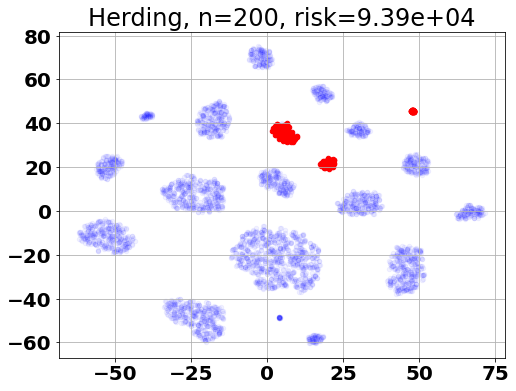

In [142]:
tag = f'Herding, n={n}'
coreset = herding(gmm_dataset['fea'], n, print_freq=n//5)
solution_ = solve_ridge_regression(para_grid, gmm_dataset['fea'][coreset], gmm_dataset['label'][coreset])
risk, tscore, escore = check_risks(solution_, gmm_dataset['ground_truth'], gmm_dataset['fea'], gmm_dataset['label'], f'RR risk: ', coreset)
tsne_visualization(gmm_dataset, coreset=coreset, tag=tag+f', risk={risk:.2e}')
risks.append(risk)
tscores.append(tscore)
escores.append(escore)

## K-center greedy
* Adapting https://github.com/PatrickZH/DeepCore/blob/main/deepcore/methods/kcentergreedy.py

In [143]:
def k_center_greedy(matrix, n, random_seed=None, index=None, print_freq=20):
    if type(matrix) == torch.Tensor:
        assert matrix.dim() == 2
    elif type(matrix) == np.ndarray:
        assert matrix.ndim == 2
        matrix = torch.from_numpy(matrix).float().requires_grad_(False)

    sample_num = matrix.shape[0]
    assert sample_num >= 1

    if n < 0:
        raise ValueError("Illegal budget size.")
    elif n > sample_num:
        n = sample_num

    if index is not None:
        assert matrix.shape[0] == len(index)
    else:
        index = np.arange(sample_num)

    with torch.no_grad():
        np.random.seed(random_seed)
        select_result = np.zeros(sample_num, dtype=bool)
        # Randomly select one initial point.
        already_selected = [np.random.randint(0, sample_num)]
        n -= 1
        select_result[already_selected] = True

        num_of_already_selected = np.sum(select_result)

        # Initialize a (num_of_already_selected + n - 1) * sample_num matrix storing distances of pool points from
        # each clustering center.
        dis_matrix = -1 * torch.ones([num_of_already_selected + n - 1, sample_num], requires_grad=False)

        dis_matrix[:num_of_already_selected, ~select_result] = euclidean_dist(matrix[select_result], matrix[~select_result])

        mins = torch.min(dis_matrix[:num_of_already_selected, :], dim=0).values

        for i in range(n):
            if i % print_freq == 0:
                print("| Selecting [%3d/%3d]" % (i + 1, n))
            p = torch.argmax(mins).item()
            select_result[p] = True

            if i == n - 1:
                break
            mins[p] = -1
            dis_matrix[num_of_already_selected + i, ~select_result] = euclidean_dist(matrix[[p]], matrix[~select_result])
            mins = torch.min(mins, dis_matrix[num_of_already_selected + i])
    return index[select_result]

| Selecting [  1/199]
| Selecting [ 41/199]
| Selecting [ 81/199]
| Selecting [121/199]
| Selecting [161/199]
Best parameters: 4.64e+01
RR risk: 2.86e+01, theta relative error: 9.74e-01, trace score: 1.60e+02, eigenvalue score: 2.12e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/Users/ydong/opt/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


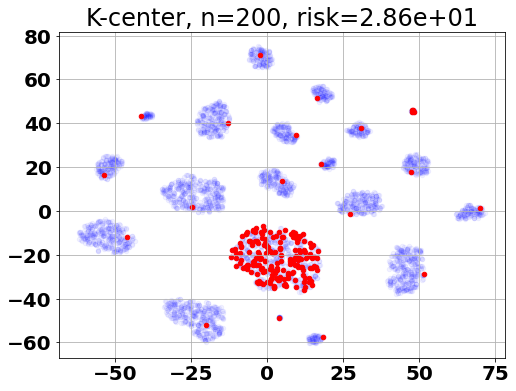

K-center, n=200, risk=2.86e+01 +- 0.00e+00


In [144]:
loss = []
for seed in np.random.randint(0, 100, 1):
    tag = f'K-center, n={n}'
    coreset = k_center_greedy(gmm_dataset['fea'], n, random_seed=seed, print_freq=n//5)
    solution_ = solve_ridge_regression(para_grid, gmm_dataset['fea'][coreset], gmm_dataset['label'][coreset])
    risk, tscore, escore = check_risks(solution_, gmm_dataset['ground_truth'], gmm_dataset['fea'], gmm_dataset['label'], f'RR risk: ', coreset)
    tsne_visualization(gmm_dataset, coreset=coreset, tag=tag+f', risk={risk:.2e}')
    risks.append(risk)
    tscores.append(tscore)
    escores.append(escore)
    loss.append(risk)
print(f'K-center, n={n}, risk={np.mean(loss):.2e} +- {np.std(loss):.2e}')

# Trace score v.s. risk

135 135 135


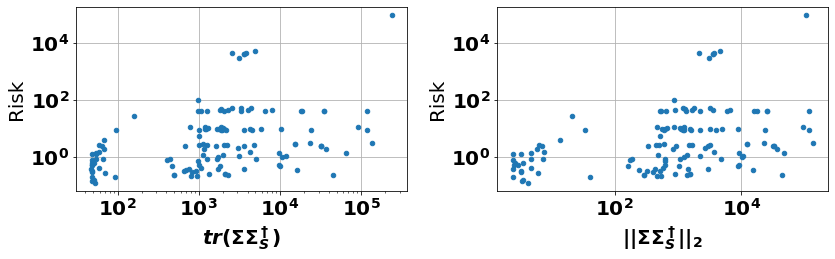

In [145]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
ax = axs[0]
ax.plot(tscores, risks, '.')
ax.set_ylabel('Risk')
ax.set_xlabel(r'$tr(\Sigma \Sigma_S^\dagger)$')
ax.set_yscale('log')
ax.set_xscale('log')

ax = axs[1]
ax.plot(escores, risks, '.')
ax.set_ylabel('Risk')
ax.set_xlabel(r'$\|\|\Sigma \Sigma_S^\dagger\|\|_2$')
ax.set_yscale('log')
ax.set_xscale('log')
plt.tight_layout()

print(len(tscores), len(escores), len(risks))

In [104]:
scores_dict = dict()
ns = [40]
ntrials = 100

## Test with only uniform sampling

In [105]:
risks = []
tscores = []
escores = []

for seed in np.random.randint(0, 1000, ntrials):
    for n in ns:
        tag = f'Uniform, n={n}'
        rng = np.random.default_rng(seed=seed)
        coreset = rng.choice(N, n, replace=False)
        solution_uniform_rr = solve_ridge_regression(para_grid, gmm_dataset['fea'][coreset], gmm_dataset['label'][coreset])
        risk, tscore, escore = check_risks(solution_uniform_rr, gmm_dataset['ground_truth'], gmm_dataset['fea'], gmm_dataset['label'], f'RR risk: ', coreset, verbose=False)
        risks.append(risk)
        tscores.append(tscore)
        escores.append(escore)
        # if seed==0:
        #     tsne_visualization(gmm_dataset, coreset=coreset, tag=tag+f', risk={risk:.2e}')
        
scores_dict['Uniform'] = {'risk': risks, 'tscore': tscores, 'escore': escores}

Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 2.22e+01
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 6.67e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 5.56e+01
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 4.44e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 6.67e+01
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 4.44e+01
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.00e-03
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


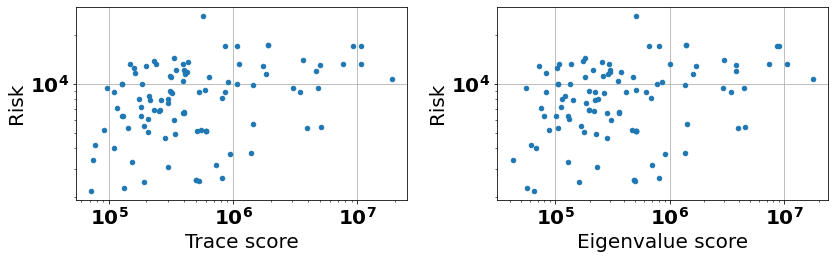

In [106]:
scores = scores_dict['Uniform']
fig, axs = plt.subplots(1, 2, figsize=(12,4))
ax = axs[0]
ax.plot(scores['tscore'], scores['risk'], '.')
ax.set_ylabel('Risk')
ax.set_xlabel('Trace score')
ax.set_yscale('log')
ax.set_xscale('log')

ax = axs[1]
ax.plot(scores['escore'], scores['risk'], '.')
ax.set_ylabel('Risk')
ax.set_xlabel('Eigenvalue score')
ax.set_yscale('log')
ax.set_xscale('log')
plt.tight_layout()

## Test with only R-leverage

In [107]:
risks = []
tscores = []
escores = []

for seed in np.random.randint(0, 1000, ntrials):
    for n in ns:
        tag = f'R-leverage, n={n}'
        leverage_scores = get_ridge_leverage_score(gmm_dataset, alpha=1e3)
        rng = np.random.default_rng(seed=seed)
        coreset = rng.choice(N, n, p=leverage_scores/np.sum(leverage_scores), replace=False)

        solution_uniform_rr = solve_ridge_regression(para_grid, gmm_dataset['fea'][coreset], gmm_dataset['label'][coreset])
        risk, tscore, escore = check_risks(solution_uniform_rr, gmm_dataset['ground_truth'], gmm_dataset['fea'], gmm_dataset['label'], f'RR risk: ', coreset, verbose=False)
        risks.append(risk)
        tscores.append(tscore)
        escores.append(escore)
        
scores_dict['R-leverage'] = {'risk': risks, 'tscore': tscores, 'escore': escores}

Best parameters: 1.00e-03
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01
Best parameters: 8.89e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 5.56e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 6.67e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 7.78e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 4.44e+01
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


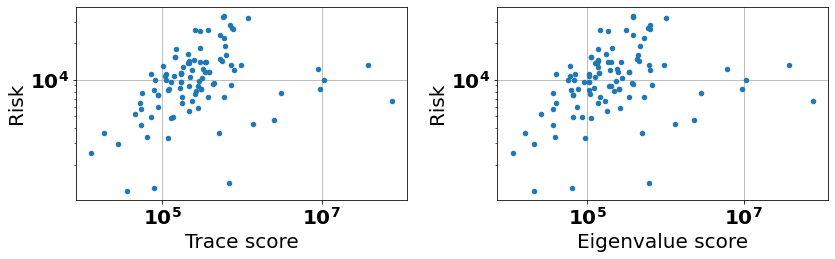

In [108]:
scores = scores_dict['R-leverage']
fig, axs = plt.subplots(1, 2, figsize=(12,4))
ax = axs[0]
ax.plot(scores['tscore'], scores['risk'], '.')
ax.set_ylabel('Risk')
ax.set_xlabel('Trace score')
ax.set_yscale('log')
ax.set_xscale('log')

ax = axs[1]
ax.plot(scores['escore'], scores['risk'], '.')
ax.set_ylabel('Risk')
ax.set_xlabel('Eigenvalue score')
ax.set_yscale('log')
ax.set_xscale('log')
plt.tight_layout()

## Test with only S-leverage

In [109]:
risks = []
tscores = []
escores = []

sketch_dim = 100
for seed in np.random.randint(0, 1000, ntrials):
    for n in ns:
        tag = f'S-leverage, n={n}'
        leverage_scores = get_sketched_ridge_leverage_score(gmm_dataset['fea'], sketch_dim, alpha=1e5)
        rng = np.random.default_rng(seed=seed)
        coreset = rng.choice(N, n, p=leverage_scores/np.sum(leverage_scores), replace=False)

        solution_uniform_rr = solve_ridge_regression(para_grid, gmm_dataset['fea'][coreset], gmm_dataset['label'][coreset])
        risk, tscore, escore = check_risks(solution_uniform_rr, gmm_dataset['ground_truth'], gmm_dataset['fea'], gmm_dataset['label'], f'RR risk: ', coreset, verbose=False)
        risks.append(risk)
        tscores.append(tscore)
        escores.append(escore)
        
scores_dict['S-leverage'] = {'risk': risks, 'tscore': tscores, 'escore': escores}

Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 4.44e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 7.78e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 7.78e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 5.56e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


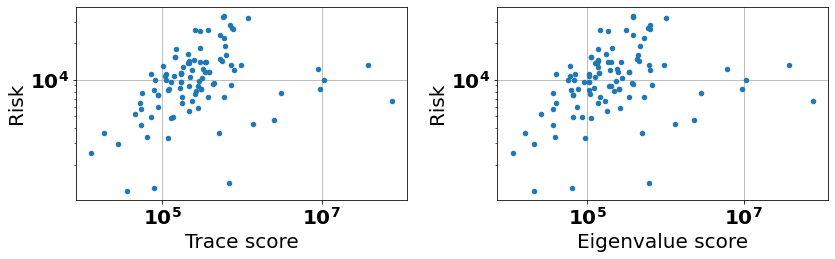

In [110]:
scores = scores_dict['R-leverage']
fig, axs = plt.subplots(1, 2, figsize=(12,4))
ax = axs[0]
ax.plot(scores['tscore'], scores['risk'], '.')
ax.set_ylabel('Risk')
ax.set_xlabel('Trace score')
ax.set_yscale('log')
ax.set_xscale('log')

ax = axs[1]
ax.plot(scores['escore'], scores['risk'], '.')
ax.set_ylabel('Risk')
ax.set_xlabel('Eigenvalue score')
ax.set_yscale('log')
ax.set_xscale('log')
plt.tight_layout()

## Test with only SkMMv2

In [111]:
risks = []
tscores = []
escores = []

for seed in np.random.randint(0, 1000, ntrials):
    for n in ns:
        tag = f'R-leverage, n={n}'
        rng = np.random.default_rng(seed=seed)
        coreset = SkMMv2(gmm_dataset['fea'], n, 100, b=1, rng=rng, temperature=1e-3, sampler='exp')

        solution_uniform_rr = solve_ridge_regression(para_grid, gmm_dataset['fea'][coreset], gmm_dataset['label'][coreset])
        risk, tscore, escore = check_risks(solution_uniform_rr, gmm_dataset['ground_truth'], gmm_dataset['fea'], gmm_dataset['label'], f'RR risk: ', coreset, verbose=False)
        risks.append(risk)
        tscores.append(tscore)
        escores.append(escore)
        
scores_dict['SkMMv2'] = {'risk': risks, 'tscore': tscores, 'escore': escores}

Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 2.22e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 2.22e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 5.56e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 6.67e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 8.89e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02
Best parameters: 7.78e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 2.22e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 8.89e+01
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 3.33e+01
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03
Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01
Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e-03


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.11e+01
Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]
/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


Best parameters: 1.00e+02


/var/folders/28/qmzcxslx3b5_gwt53j7sr5540000gn/T/ipykernel_2794/4133338536.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  GG_Sinv = np.linalg.lstsq(skfeature_for_scores[coreset].T, skfeature_for_scores.T)[0]


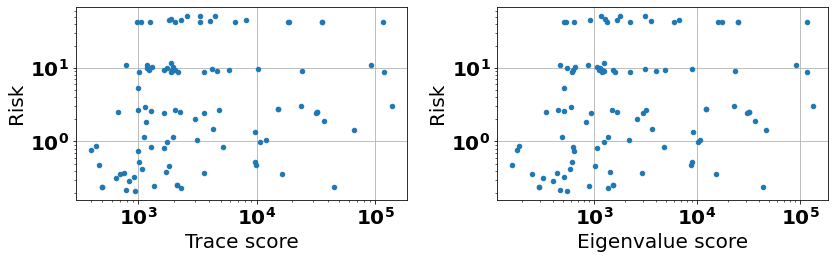

In [112]:
scores = scores_dict['SkMMv2']
fig, axs = plt.subplots(1, 2, figsize=(12,4))
ax = axs[0]
ax.plot(scores['tscore'], scores['risk'], '.')
ax.set_ylabel('Risk')
ax.set_xlabel('Trace score')
ax.set_yscale('log')
ax.set_xscale('log')

ax = axs[1]
ax.plot(scores['escore'], scores['risk'], '.')
ax.set_ylabel('Risk')
ax.set_xlabel('Eigenvalue score')
ax.set_yscale('log')
ax.set_xscale('log')
plt.tight_layout()

## Overall plot

risk2mm_n40_4000x4200x20


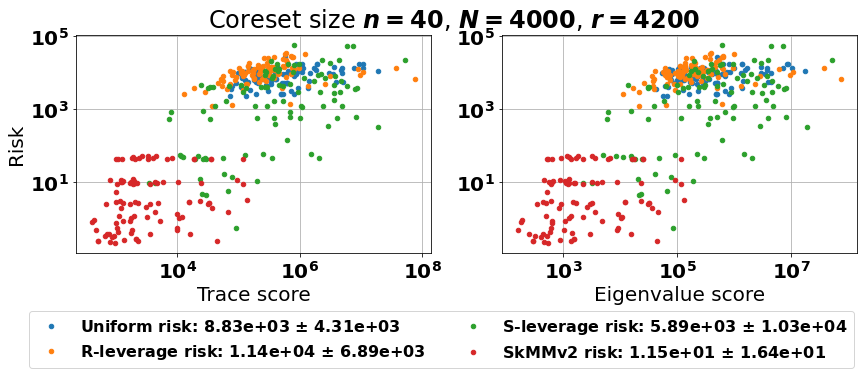

In [113]:
fig, axs = plt.subplots(1, 2, figsize=(14,4))
algos = ['Uniform', 'R-leverage', 'S-leverage', 'SkMMv2']
for i, key in enumerate(algos):
    scores = scores_dict[key] 
    ax = axs[0]
    ax.plot(scores['tscore'], scores['risk'], '.', color=colors_10[i], label=key)
    ax.set_ylabel('Risk')
    ax.set_xlabel('Trace score')
    ax.set_yscale('log')
    ax.set_xscale('log')

    ax = axs[1]
    ax.plot(scores['escore'], scores['risk'], '.', color=colors_10[i], label=f'{key} risk: {np.mean(scores["risk"]):.2e} $\pm$ {np.std(scores["risk"]):.2e}')
    # ax.set_ylabel('Risk')
    ax.set_xlabel('Eigenvalue score')
    ax.set_yscale('log')
    ax.set_xscale('log')

line, label = axs[-1].get_legend_handles_labels() 
lgd = fig.legend(line, label, loc='upper left', bbox_to_anchor=(0.07,-0.05), ncol=2,)
N, r, n_cls = gmm_dataset['N'], gmm_dataset['r'], gmm_dataset['n_cls']
tit = fig.suptitle(rf'Coreset size $n={ns[0]:d}$, $N={N:d}$, $r={r:d}$') 
print(f'risk2mm_n{ns[0]:d}_{N:d}x{r:d}x{n_cls:d}')

# Plots

In [ ]:
n_list = [48, 64, 80, 120, 200, 400, 800, 1600]
risk_dict = {
    'skmm': {'mean':[],
             'std':[]},
    'unif': {'mean':[],
             'std': []},
    'adas': {'mean':[],
             'std':[]},
    'tlev': {'mean':[],
             'std':[]},
    'rlev': {'mean':[],
             'std': []},
}
label_dict = {
    'skmm': 'SkMM (ours)',
    'unif': 'Uniform',
    'adas': 'Adaptive sampling',
    'tlev': 'Leverage score',
    'rlev': 'Ridge leverage',
}
marker_dict = {
    'skmm': 'o',
    'unif': '^',
    'adas': 's',
    'tlev': 'p',
    'rlev': 'd',
}
marker_size_dict = {
    'skmm': 16,
    'unif': 8,
    'adas': 8,
    'tlev': 8,
    'rlev': 8,
}
color_dict = {
    'skmm': colors_10[0],
    'unif': colors_10[1],
    'adas': colors_10[2],
    'tlev': colors_10[3],
    'rlev': colors_10[4],
}

plt.figure(figsize=(6,7))
for key, value in risk_dict.items():
    mean, std = np.array(value['mean']), np.array(value['std'])
    # plt.errorbar(n_list, mean, yerr=std, fmt=marker_dict[key]+'-', label=label_dict[key], markersize=marker_size_dict[key], linewidth=1)
    plt.fill_between(n_list, mean-std, mean+std, alpha=0.2, color=color_dict[key])
    plt.loglog(n_list, mean, marker_dict[key]+'-', label=label_dict[key], markersize=marker_size_dict[key], linewidth=1, color=color_dict[key])
    ax = plt.gca()
    ax.set_xlabel('$|S| = n$')
    ax.set_ylabel(r'$\frac{1}{N} \|\| \phi(X) \theta_S - y \|\|_2^2$')
    # ax.set_ylim([1e-3, 2e2])
    handles, plabels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, plabels, ncol=1) # loc='upper left', bbox_to_anchor=(-0.26, -0.24),